<div style="background-color: darkred; padding: 10px; color: white;">

# Training Soma Classifier

</div>

<div style="background-color: darkblue; padding: 10px; color: white;">

## Section 1: Load Training Data
    
</div>

### Imports

In [1]:
from random import sample

from aind_exaspim_soma_detection.utils import util
from aind_exaspim_soma_detection.training import data_handling
from aind_exaspim_soma_detection.training.data_handling import SomaDataset

%matplotlib inline

### Initializations

In [2]:
# Parameters
anisotropy = [0.748, 0.748, 1.0]
multiscale = 2
patch_shape = (64, 64, 64)

# Paths
img_lookup_path =  "/root/capsule/data/exaspim_image_prefixes.json"
smartsheet_path = "/root/capsule/data/Neuron_Reconstructions.xlsx"
exaspim_soma_path = "/root/capsule/data/exaspim_somas_2024"


### Load Data

In [3]:
# SmartSheet Data
smartsheet_data = data_handling.fetch_smartsheet_somas(
    smartsheet_path,
    img_lookup_path,
    multiscale=multiscale,
)

# ExaSPIM Soma Data
exapsim_data = data_handling.fetch_exaspim_somas_2024(
    exaspim_soma_path,
    img_lookup_path,
    multiscale=multiscale,
)

# Initialize Dataset
soma_dataset = SomaDataset(patch_shape, transform=True)
for example_tuple in smartsheet_data + exapsim_data:
    soma_dataset.ingest_examples(*example_tuple)

print("# Examples:", soma_dataset.n_examples())
print("# Positive Examples", soma_dataset.n_positives())
print("# Negative Examples", soma_dataset.n_negatives())

/opt/conda/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


# Examples: 2677
# Positive Examples 1884
# Negative Examples 793


### Visualize Training Example

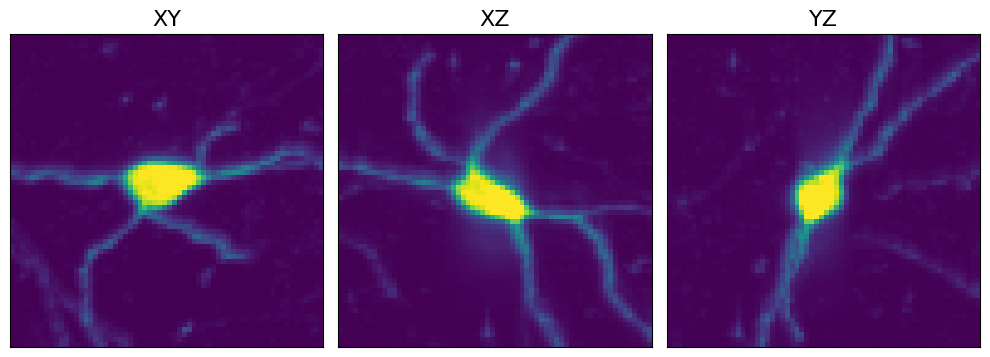

In [4]:
key = util.sample_once(soma_dataset.examples.keys())
soma_dataset.visualize_example(key)

### Visualize Augmented Training Example

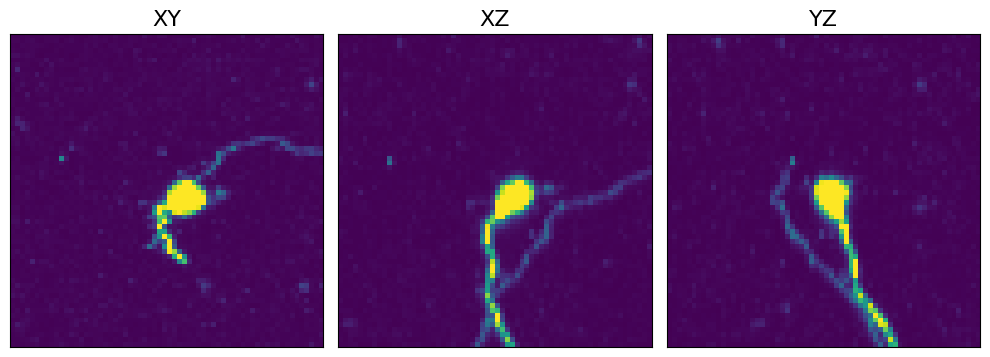

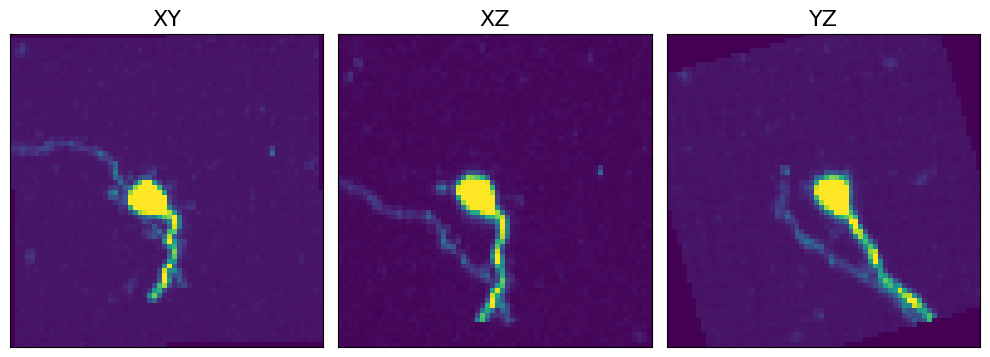

In [5]:
key = util.sample_once(soma_dataset.examples.keys())
soma_dataset.visualize_augmented_example(key)

<div style="background-color: darkblue; padding: 10px; color: white;">

## Section 2: Train Model
    
</div>

### Imports

In [6]:
from torch.optim.lr_scheduler import StepLR

import torch
import torch.nn as nn
import torch.optim as optim

from aind_exaspim_soma_detection.training.data_handling import MultiThreadedDataLoader
from aind_exaspim_soma_detection.training.models import Fast3dCNN

### Subroutines

In [7]:
def partition(super_list, sub_list):
    return list(filter(lambda x: x not in sub_list, super_list))


def split_train_validation(examples, train_ratio):
    # Get numbers of examples
    n_train_examples = int(train_ratio * len(examples))
    n_valid_examples = len(examples) - n_train_examples

    # Sample keys
    train_keys = sample(examples.keys(), n_train_examples)
    valid_keys = partition(examples.keys(), train_keys)

    # Get examples
    train_examples = dict({k: examples[k] for k in train_keys})
    valid_examples = dict({k: examples[k] for k in valid_keys})
    return train_examples, valid_examples


def merge_examples(soma_dataset, positives, negatives):
    examples = list()
    combined_dict = positives.copy()
    combined_dict.update(negatives)
    for key, value in combined_dict.items():
        brain_id, voxel = key
        img_path = soma_dataset.img_paths[brain_id]
        examples.append((brain_id, img_path, [voxel], [value]))
    return examples


def init_subdataset(dataset, positives, negatives, patch_shape, transform):
    subdataset = SomaDataset(patch_shape, transform=transform)
    for example_tuple in merge_examples(dataset, positives, negatives):
        subdataset.ingest_examples(*example_tuple)
    return subdataset


### Initialize Datasets

In [8]:
# Parameters
transform = True
train_ratio = 0.85

# Train-Validation Split - Negative examples
train_negatives, valid_negatives = split_train_validation(
    soma_dataset.get_negatives(), train_ratio
)

# Train-Validation Split - Positive examples
n_negatives = len(train_negatives) + len(valid_negatives)
positives_keys = sample(soma_dataset.get_positives().keys(), n_negatives)
positive_examples = dict({k: soma_dataset.examples[k] for k in positives_keys})
train_positives, valid_positives = split_train_validation(
    positive_examples, train_ratio
)

# Train-Validation Datasets
train_soma_dataset = init_subdataset(
    soma_dataset, train_positives, train_negatives, patch_shape, True
)
valid_soma_dataset = init_subdataset(
    soma_dataset, valid_positives, valid_negatives, patch_shape, False
)

### Training Loop

In [9]:
# Parameters
batch_size = 16
lr = 1e-4
lr_gamma = 0.8
lr_step_size = 20
n_epochs = 100

# Initializations
criterion = nn.BCEWithLogitsLoss()
dataloader = MultiThreadedDataLoader(train_soma_dataset, batch_size)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Fast3dCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

# Main
model #.to(device)
for epoch in range(n_epochs):
    # Train model
    print(f"Epoch {epoch}:")
    model.train()
    for i, (x, y) in enumerate(dataloader):
        # Forward pass
        x, y = x.to(device), y.to(device)
        hat_y = model(x)
        loss = criterion(hat_y, y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validate model

    # Step the scheduler
    scheduler.step()

Epoch 0:



KeyboardInterrupt

